In this notebook I want to illustrate how one can use our `[...]FromFolder` functionalities along with the `[...]ChunkPreProcessors` in those cases where the dataset is too bit to fit in memory.

These functionalities in the library have been designed for the following scenarop

### Scenario

We have a tabular dataset combined with images and text and either some, or all these datasets do not fit in memory. Note that the tabular dataset **MUST ALWAYS** be present as it is considered the rerefence. This is, if we have an image dataset, the tabular dataset must contain a column that points to the image file names as stored in disk. Similarly, if we have a text dataset, then the tabular dataset must contain a column with the texts themselves or a the file names of the text files as stored in disk. 

If you only have text and/or images and not a tabular component, I would suggest using other libraries (such as hugginface probably). 

Within this scenario, they are two possible scenarios that we will cover here: 

1. The tabular data itsel fits in memory and is only the images that do not: in this case you could use the '*standard*' `Preprocessors` in the library and off you go, move directly to the `[...]FromFolder` functionalities

2. The tabular data is also very large and does not fit in memory, so we have to process it in chuncks. For this second case I have created the so called `Chunk[...]Preprocessor` (Wide, Tab and Text). 

Note that at the moment **ONLY csv** format is allowed for the tabular file. More formats will be supported in the future.

Let's see a complete example to illustrate how each of these cases would be addressed with the new functionalities in the library. For this example we will use a sample of the airbnb dataset

The airbnb dataset, which you could get from [here](http://insideairbnb.com/get-the-data.html), is too big to be included in our datasets module (when including images). Therefore, what I did was, go there, download it, and use the download_images.py script to get the images and the airbnb_data_processing.py to process the data. I did this ages ago and I believe the format of the dataset might be different now. Nonetheless, I will show samples of the dataset as we go through so you can extrapolate the content of this notebook to your particular problem. 

In the future we will find better datasets🙂. Finally, note that here we are only using a small sample to illustrate the use, so PLEASE ignore the results, just focus on usage. 

In [1]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader

from pytorch_widedeep.models import TabMlp, Vision, BasicRNN, WideDeep
from pytorch_widedeep.training import TrainerFromFolder
from pytorch_widedeep.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_widedeep.preprocessing import (
    TabPreprocessor,
    TextPreprocessor,
    ImagePreprocessor,
    ChunkTabPreprocessor,
    ChunkTextPreprocessor,
)
from pytorch_widedeep.load_from_folder import (
    TabFromFolder,
    TextFromFolder,
    ImageFromFolder,
    WideDeepDatasetFromFolder,
)

In [2]:
# in my case, I place the data in a folder I call tmp_data, let's see how it looks
airbnb_data = pd.read_csv("../tmp_data/airbnb/airbnb_sample.csv")
airbnb_data.sample(5)

,id,host_id,description,host_listings_count,host_identity_verified,neighbourhood_cleansed,latitude,longitude,is_location_exact,property_type,...,amenity_wide_entrance,amenity_wide_entrance_for_guests,amenity_wide_entryway,amenity_wide_hallways,amenity_wifi,amenity_window_guards,amenity_wine_cooler,security_deposit,extra_people,yield
111,97583.jpg,516216,Very peaceful Edwardian house with beautiful f...,3.0,t,Haringey,51.60796,-0.12551,f,house,...,0,0,0,0,1,0,0,100.0,0.0,57.82
110,97506.jpg,497537,"Hi, we want our guests to have a great time wh...",1.0,t,Lambeth,51.42875,-0.12056,t,apartment,...,0,0,0,0,1,0,0,0.0,20.0,11.20
921,530432.jpg,2604870,A modern and luxurious 2 bedroom apartment clo...,1.0,f,Tower Hamlets,51.52312,-0.01305,t,apartment,...,0,0,0,0,1,0,0,85.0,15.0,48.18
350,315658.jpg,1620906,A comfortable double room in an apartment bloc...,2.0,t,Lambeth,51.48366,-0.11658,t,apartment,...,0,0,0,0,1,0,0,0.0,0.0,219.42
598,412652.jpg,1199826,"Great room, great central London location, ver...",1.0,t,Tower Hamlets,51.52334,-0.05232,t,apartment,...,0,0,0,0,1,0,0,0.0,10.0,200.08


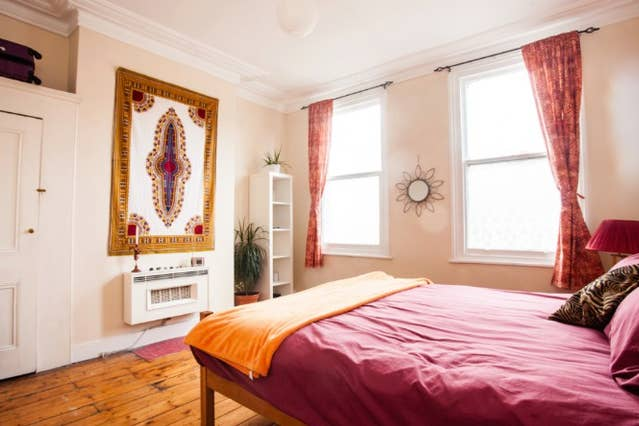

In [3]:
# for example
from IPython.display import Image

pil_img = Image(filename="../tmp_data/airbnb/property_picture/272908.jpg")
display(pil_img)

In [4]:
# And the description for the property that that picture belongs to is:
airbnb_data[airbnb_data.id == "272908.jpg"].description.tolist()

["Bright, sunny beautiful room that will give you the perfect base to explore all of London. Come and explore one of London's best neighbourhoods - Herne Hill! As mentioned in (Website hidden by Airbnb)   (Website hidden by Airbnb)  WiFi availability with a fully stocked and clean uplifting home. Lovely sunny, airy and big double bedroom on a leafy south-London street.    Note: This room comes with a reserved Off-Street parking spot! The room is on the first floor and boasts an enormous Super King bed, gorgeous wooden floors, tall ceilings and large windows which let in the sunshine almost all day. (Yoga May or meditation cushion available on request) The flat is bright and airy and big! So lots of space for all.  Location wise you are only 10 minutes walk to either Herne Hill or West Dulwich stations, both of which will take you to Victoria and the city within minutes. You can also hop on a bus right outside the flat that will take you to Brixton tube station within 8 minutes where yo

Ok, so we have tabular data where one column is `description` and another `id`, points towards the images stored in disk. Now, remember the following, because this will appear a few times in the notebook: our "reference dataset" is the tabular data. 

Therefore, since I want to illustrate a "semi-realistic" case, if we need to split the data into training, validation and test datasets, these datasets needs to be separetely stored in disk. In my case I have done this and in the `tmp_data/airbnb` dir I have the following:

```bash
../tmp_data/airbnb
├── airbnb_sample.csv
├── airbnb_sample_eval.csv
├── airbnb_sample_test.csv
├── airbnb_sample_train.csv
└── property_picture
```

Where `airbnb_sample.csv` is the full sample (1001 rows) and the `train`, `eval` and `test` set is the corresponding splits. In a realistic example, the full sample would be the '_gigantic_' dataset and the rest the corresponding splits. One has to do this 'offline', prior to start the coding. 

Also, one thing that one needs to know is the number of total observations/rows, as well as the splits. In our case the train size is 800, and the eval and test sizes are 100 and 101 respectively. 

With all that info, let's star

## Setting variables and constants

In [5]:
# path to the tabular data and the splits
data_path = "../tmp_data/airbnb/"
train_fname = "airbnb_sample_train.csv"
eval_fname = "airbnb_sample_eval.csv"
test_fname = "airbnb_sample_test.csv"

# split sizes
train_size = 800
eval_size = 100
test_size = 101

# number of chunks for the Chunk Preprocessors
chunksize = 100
n_chunks = int(np.ceil(train_size / chunksize))

# path to the image dataset and name of the image col
img_path = "../tmp_data/airbnb/property_picture/"
img_col = "id"

# name of the text col
text_col = "description"

# mane of the target
target_col = "yield"

# definition of the categorical and continuous cols for the TabPreprocessor
cat_embed_cols = [
    "host_listings_count",
    "neighbourhood_cleansed",
    "is_location_exact",
    "property_type",
    "room_type",
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "guests_included",
    "minimum_nights",
    "instant_bookable",
    "cancellation_policy",
    "has_house_rules",
    "host_gender",
    "accommodates_catg",
    "guests_included_catg",
    "minimum_nights_catg",
    "host_listings_count_catg",
    "bathrooms_catg",
    "bedrooms_catg",
    "beds_catg",
    "security_deposit",
    "extra_people",
]
cont_cols = ["latitude", "longitude"]

## Step 1: the preprocessors

### Scenario 1: only the images do not fit in disk

In this case we can prepare the data in the '_standard_' way

In [6]:
tab_preprocessor = TabPreprocessor(
    embed_cols=cat_embed_cols,
    continuous_cols=cont_cols,
    default_embed_dim=8,
    verbose=0,
)

text_preprocessor = TextPreprocessor(
    text_col=text_col,
    n_cpus=1,
)

img_preprocessor = ImagePreprocessor(
    img_col=img_col,
    img_path=img_path,
)

In [7]:
tab_preprocessor.fit(airbnb_data)
text_preprocessor.fit(airbnb_data)
img_preprocessor.fit(airbnb_data)

The vocabulary contains 2192 tokens


ImagePreprocessor(img_col=id, img_path=../tmp_data/airbnb/property_picture/, width=224, height=224, verbose=1)

### Scenario 2: the tabular data is also huge 

Then we need to prepare it in chunks. Note that, unfortunately, the tabular and text preprocessors need to see the whole dataset once. This is because to process tabular or text data we need to encode values. For those encodings to be consistent they need to have seen the whole dataset. Alternatively, one could code a solution with some streaming encoder for both datasets. However, such implementation is not trivial for this library (and in general). I also don't think that having to see the whole data once is such a big limitation. Let's see how is done.

Note that I have not mentioned the image dataset. This is because the processing of the image dataset does not require any form of encoding and in consequence can be done 'on the fly'. Therefore, no `ChunkImgPreprocessor` processor is needed.

In [8]:
chunk_tab_preprocessor = ChunkTabPreprocessor(
    embed_cols=cat_embed_cols,
    continuous_cols=cont_cols,
    n_chunks=n_chunks,
    default_embed_dim=8,
    verbose=0,
)

chunk_text_preprocessor = ChunkTextPreprocessor(
    n_chunks=n_chunks,
    text_col=text_col,
    n_cpus=1,
    verbose=0,
)

for i, chunk in enumerate(
    pd.read_csv("/".join([data_path, train_fname]), chunksize=chunksize)
):
    print(f"chunk in loop: {i + 1}")
    chunk_tab_preprocessor.fit(chunk)
    chunk_text_preprocessor.fit(chunk)

chunk in loop: 1
chunk in loop: 2
chunk in loop: 3
chunk in loop: 4
chunk in loop: 5
chunk in loop: 6
chunk in loop: 7
chunk in loop: 8


## Step 2: the `[...]FromFolder` classes

Once we have the preprocessors, we need to instantiate the classes that will enable us to load the data from their respective folders. From now on I am going to proceed with the `chunk_tab_preprocessor`, `chunk_text_preprocessor` and `img_preprocessor`, but the code would be identical if instead of the first two preprocessors we decided to use the `tab_preprocessor` and `text_preprocessor`.

Once more, our reference datasets are the tabular datasets, which we have splitted in train, eval and test prior to start the coding. Therefore, we will eventually need a loader for each split

In [9]:
train_tab_folder = TabFromFolder(
    fname=train_fname,
    directory=data_path,
    target_col=target_col,
    preprocessor=tab_preprocessor,
    text_col=text_col,
    img_col=img_col,
)

# Note how we can use the `train_tab_folder` as reference so we don't have to
# define all parameters again
eval_tab_folder = TabFromFolder(fname=eval_fname, reference=train_tab_folder)

# Note that for the test set we can ignore the target as no metric will be
# computed by the `predict` method
test_tab_folder = TabFromFolder(
    fname=test_fname, reference=train_tab_folder, ignore_target=True
)

In [10]:
# for the text and image datasets we do not need to specify eval or test loaders
text_folder = TextFromFolder(preprocessor=text_preprocessor)
img_folder = ImageFromFolder(preprocessor=img_preprocessor)

## Step 3: pytorch datasets and dataloaders

From here in advance, is all very 'standard' if you are familiar with pytorch. One needs to define a class that inherits from the `Dataset` class in pytorch. Then this will be passed to a `DataLoader` class and we are ready to train. Our `Dataset` child class is `WideDeepDatasetFromFolder`. This class will use the tabular dataset and the corresponding text and image columns to load the adequate data in the batches

Let's do it

In [11]:
train_dataset_folder = WideDeepDatasetFromFolder(
    n_samples=train_size,
    tab_from_folder=train_tab_folder,
    text_from_folder=text_folder,
    img_from_folder=img_folder,
)

# Note that the eval and test loaders only need their corresponding
# `TabFromFolder` classes. The rest of the parameters can be defined
# via a `reference` `TabFromFolder` class
eval_dataset_folder = WideDeepDatasetFromFolder(
    n_samples=eval_size,
    tab_from_folder=eval_tab_folder,
    reference=train_dataset_folder,
)

test_dataset_folder = WideDeepDatasetFromFolder(
    n_samples=test_size,
    tab_from_folder=test_tab_folder,
    reference=train_dataset_folder,
)

In [12]:
train_loader = DataLoader(train_dataset_folder, batch_size=16, num_workers=1)
eval_loader = DataLoader(eval_dataset_folder, batch_size=16, num_workers=1)
test_loader = DataLoader(test_dataset_folder, batch_size=16, num_workers=1)

And from here on is business as usual: 

## Step 4: define the model 

In [13]:
# for example
basic_rnn = BasicRNN(
    vocab_size=len(text_preprocessor.vocab.itos),
    embed_dim=32,
    hidden_dim=64,
    n_layers=2,
)

deepimage = Vision()

deepdense = TabMlp(
    mlp_hidden_dims=[32, 16],
    column_idx=tab_preprocessor.column_idx,
    cat_embed_input=tab_preprocessor.cat_embed_input,
    continuous_cols=cont_cols,
)

model = WideDeep(
    deeptabular=deepdense,
    deeptext=basic_rnn,
    deepimage=deepimage,
)

model

WideDeep(
  (deeptabular): Sequential(
    (0): TabMlp(
      (cat_and_cont_embed): DiffSizeCatAndContEmbeddings(
        (cat_embed): DiffSizeCatEmbeddings(
          (embed_layers): ModuleDict(
            (emb_layer_host_listings_count): Embedding(28, 10, padding_idx=0)
            (emb_layer_neighbourhood_cleansed): Embedding(33, 11, padding_idx=0)
            (emb_layer_is_location_exact): Embedding(3, 2, padding_idx=0)
            (emb_layer_property_type): Embedding(4, 3, padding_idx=0)
            (emb_layer_room_type): Embedding(4, 3, padding_idx=0)
            (emb_layer_accommodates): Embedding(14, 7, padding_idx=0)
            (emb_layer_bathrooms): Embedding(11, 6, padding_idx=0)
            (emb_layer_bedrooms): Embedding(7, 4, padding_idx=0)
            (emb_layer_beds): Embedding(11, 6, padding_idx=0)
            (emb_layer_guests_included): Embedding(11, 6, padding_idx=0)
            (emb_layer_minimum_nights): Embedding(25, 9, padding_idx=0)
            (emb_layer_ins

## Step 5: fit and predict

In [14]:
trainer = TrainerFromFolder(
    model,
    objective="regression",
)

trainer.fit(
    train_loader=train_loader,
    eval_loader=eval_loader,
)

valid: 100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:22<00:00,  3.19s/it, loss=6.61e+3]


In [15]:
preds = trainer.predict(test_loader=test_loader)

predict: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:23<00:00,  3.30s/it]


Note that in the case of predict you could also choose to do this

In [16]:
df_test = pd.read_csv("/".join([data_path, test_fname]))

In [17]:
# if the images for the test set fit in memory
X_tab_test = chunk_tab_preprocessor.transform(df_test)
X_text_test = chunk_text_preprocessor.transform(df_test)
X_img_test = img_preprocessor.transform(df_test)

Reading Images from ../tmp_data/airbnb/property_picture/
Resizing


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 587.63it/s]

Computing normalisation metrics


In [18]:
preds = trainer.predict(
    X_tab=X_tab_test, X_text=X_text_test, X_img=X_img_test, batch_size=32
)

predict: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]
